<a href="https://colab.research.google.com/github/nigoda/machine_learning/blob/main/29_Text_classification_with_an_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Text classification with an RNN**

https://www.tensorflow.org/text/tutorials/text_classification_rnn

This text classification trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## **Setup**

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:  

In [2]:
 import matplotlib.pyplot as plt

 def plot_graphs(history, metric):
   plt.plot(history.history[metric])
   plt.plot(history.history['val_'+metric], '')
   plt.xlabel("Epochs")
   plt.ylabel(metric)
   plt.legend([metric, 'val_'+metric])

## **Setup input pipeline**

The IMDB large movie review dataset is a *binary classification dataset*-all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://github.com/nigoda/machine_learning/blob/main/12_NLP_Load_text.ipynb) for details on how to load this sort of data manually. 

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, labels)` pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'For some strange reason the film world is driven by fashion . Someone makes a film about a killer shark then all of a sudden the film world`s oceans are awash with giant Squids , killer octopusses and sea monsters of every ilk . A man is stalked by an erstwhile lover from hell then every film character is stalked by a cop from hell or a flatmate from hell or a babysitter from hell . Then when a major Hollywood company produces a big budget FX laden blockbuster about tornados then other film producers jump upon the bandwagon , the fact that they don`t have the budget to pull it off doesn`t stop them. NIGHT OF THE TWISTERS is a case in point . What struck me about this made for television film is the fact that it tries to hide its lack of budget by cutting to the ad breaks . Everytime a tornado appears the camara locks onto the horrified expression of the actors as they scream things like " Oh my gawd it`s heading this way " and " Run for your lives " then the screen fades to 

## **Create the text encoder**

The raw text loaded bf `tfds` need to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This has many capabilities, but in this sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. after the padding and unknown tokens they're sorted by frequency:

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [10]:
encoded_example = encoder(example[:3].numpy())
encoded_example

<tf.Tensor: shape=(3, 339), dtype=int64, numpy=
array([[ 16,  47, 661, ...,   0,   0,   0],
       [ 11,  14,  56, ..., 114, 749, 461],
       [  2,   1,  12, ...,   0,   0,   0]])>

With the default settings, the process is not completely reversible. There are two main reasons for that:

*  The default value for `preprocessing.TextVectorization's` `standardize` argument is `"lower_and_strip_punctuation"`.
*  The limited vocabulary size and lack of character-based fallback result in some unknown tokens.

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'For some strange reason the film world is driven by fashion . Someone makes a film about a killer shark then all of a sudden the film world`s oceans are awash with giant Squids , killer octopusses and sea monsters of every ilk . A man is stalked by an erstwhile lover from hell then every film character is stalked by a cop from hell or a flatmate from hell or a babysitter from hell . Then when a major Hollywood company produces a big budget FX laden blockbuster about tornados then other film producers jump upon the bandwagon , the fact that they don`t have the budget to pull it off doesn`t stop them. NIGHT OF THE TWISTERS is a case in point . What struck me about this made for television film is the fact that it tries to hide its lack of budget by cutting to the ad breaks . Everytime a tornado appears the camara locks onto the horrified expression of the actors as they scream things like " Oh my gawd it`s heading this way " and " Run for your lives " then the screen fades t

## **Create the model**

![A drawing of the information flow in the model](https://www.tensorflow.org/text/tutorials/images/bidirectional.png)

Above is a diagram of the model.

1.  This model can be build as `tf.keras.Sequential`.
2.  The first is the `encoder`, which convert the text to a sequence of token indices.
3.  After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequence of vectors. These vector are trainable. After training (on enough data), Words with similar meanings often have similar vectors.

>  This index-lookup is much more efficient than the euivalent operation of passing a one-hot encoded vector through a `tf.keras,layers.Dense` layer.

> *  The main advantage of a bidirectional RNN is that the single from the beginning of the input doen't need to be processed all the way through every timestep to affect the output.

> *  The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5.  After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.

The code to implement this is below:


In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim = len(encoder.get_vocabulary()),
        output_dim = 64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

  Please note that Keras sequential model is used here since all the layer in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras function API or model subclassing so that you can retrieve and reuse the RNN layer state. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [14]:
# Predict on a sample text without padding

sample_text = ('The movie was cool. the animation and the graphics'
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-0.01019477]]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [15]:
# Predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions)

[[-0.01019477]
 [-0.04811942]]


Compile the Keras model to configure the training process:

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## **Train the model**

In [16]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=3)

Epoch 1/10
391/391 [==============================] - 701s 2s/step - loss: 0.6355 - accuracy: 0.5719 - val_loss: 0.5013 - val_accuracy: 0.7083
Epoch 2/10
391/391 [==============================] - 689s 2s/step - loss: 0.3840 - accuracy: 0.8244 - val_loss: 0.4269 - val_accuracy: 0.7760
Epoch 3/10
391/391 [==============================] - 699s 2s/step - loss: 0.3317 - accuracy: 0.8540 - val_loss: 0.4076 - val_accuracy: 0.7812
Epoch 4/10
391/391 [==============================] - 692s 2s/step - loss: 0.3196 - accuracy: 0.8613 - val_loss: 0.3962 - val_accuracy: 0.7917
Epoch 5/10
391/391 [==============================] - 688s 2s/step - loss: 0.3111 - accuracy: 0.8645 - val_loss: 0.3873 - val_accuracy: 0.8073
Epoch 6/10
391/391 [==============================] - 693s 2s/step - loss: 0.3053 - accuracy: 0.8667 - val_loss: 0.3843 - val_accuracy: 0.8073
Epoch 7/10
391/391 [==============================] - 690s 2s/step - loss: 0.3062 - accuracy: 0.8682 - val_loss: 0.3829 - val_accuracy: 0.8073

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_acc)

391/391 [==============================] - 156s 388ms/step - loss: 0.6932 - accuracy: 0.5000
Test Loss:  0.6931896209716797
Test Accuracy:  0.5


NameError: ignored

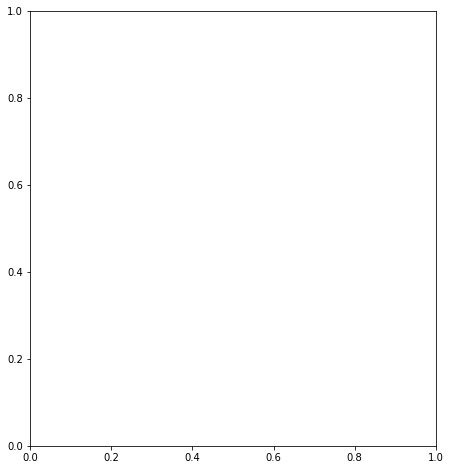

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [20]:
sample_text = ('The movie was cool. The animation and graphics'
               'were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions[0])


[-0.0083308]


## **Stack two or more LSTM layers**

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

*  If `Flase` it returns only the last output for each input sequence (a 2D tensor of shape `(batch_size, output_features)`). This is the default, used in the previous model.

*  If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_feautre)`).

Here is what the flow of information looks like with `return_sequences=True`

![layered_bidirectional](https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png)

The intresting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this: 


In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1313s 3s/step - loss: 0.5931 - accuracy: 0.6245 - val_loss: 0.4304 - val_accuracy: 0.7828
Epoch 2/10
391/391 [==============================] - 1280s 3s/step - loss: 0.3708 - accuracy: 0.8385 - val_loss: 0.3498 - val_accuracy: 0.8365
Epoch 3/10
391/391 [==============================] - 1270s 3s/step - loss: 0.3289 - accuracy: 0.8616 - val_loss: 0.3386 - val_accuracy: 0.8615
Epoch 4/10
391/391 [==============================] - 1273s 3s/step - loss: 0.3173 - accuracy: 0.8645 - val_loss: 0.3329 - val_accuracy: 0.8667
Epoch 5/10
391/391 [==============================] - 1265s 3s/step - loss: 0.3145 - accuracy: 0.8642 - val_loss: 0.3190 - val_accuracy: 0.8589
Epoch 6/10
391/391 [==============================] - 1285s 3s/step - loss: 0.3073 - accuracy: 0.8699 - val_loss: 0.3251 - val_accuracy: 0.8651
Epoch 7/10
391/391 [==============================] - 1270s 3s/step - loss: 0.3037 - accuracy: 0.8704 - val_loss: 0.3181 - val_accuracy:

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_acc)

391/391 [==============================] - 279s 713ms/step - loss: 0.3248 - accuracy: 0.8620
Test Loss:  0.32478925585746765
Test Accuracy:  0.8620399832725525


In [25]:
# Predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics'
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8099976]]


In [29]:
sample_text = ('The movie was good. The animation and graphics'
               'were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions)


[[0.49841073]]


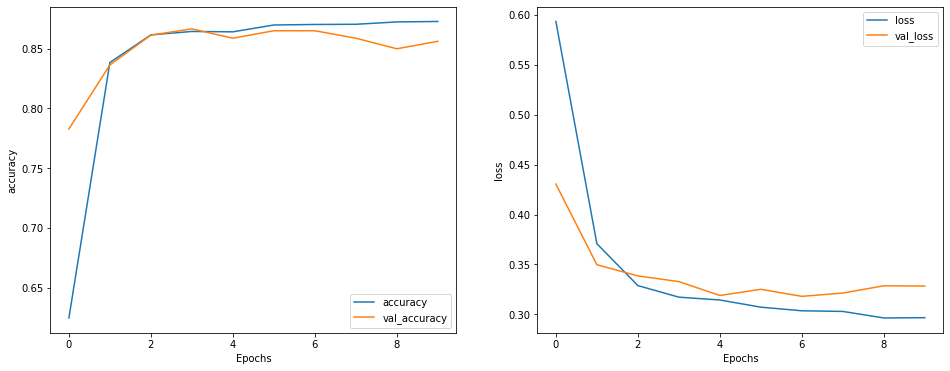

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrect layer such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're intrestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).